# Intro a CNNs

Este código define y entrena una red neuronal convolucional (CNN) para clasificar imágenes del conjunto de datos CIFAR-10. El modelo utiliza capas convolucionales, pooling, dropout y capas completamente conectadas para extraer características y realizar la predicción. CIFAR-10 contiene 60,000 imágenes divididas en 10 categorías, como autos, aves y gatos. El entrenamiento se realiza con PyTorch, aprovechando una GPU si está disponible.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

## Definición de la arquitectura de la CNN

En este bloque se define la clase CNN, que representa la red neuronal. Consiste en tres capas convolucionales para extraer características visuales, seguidas de capas totalmente conectadas para clasificar las imágenes en 10 categorías. También se incluyen capas de dropout para reducir el sobreajuste.

- **Capas convolucionales**: Detectan patrones como bordes o texturas.
- **Max Pooling**: Reduce las dimensiones de las imágenes manteniendo características relevantes.
- **Dropout**: Reduce el riesgo de sobreajuste durante el entrenamiento.
- **Capas totalmente conectadas**: Combinan las características extraídas para clasificar las imágenes.

In [2]:
# Definir la arquitectura de la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Canales de entrada, Canales de salida, Tamaño de Kernel, Stride y Padding
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 1) 
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        #Entrada (batch, channels, ancho, largo)
        # (64, 3, 32, 32)
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2) # No es una capa aprendible. (feature_maps, stride, padding)
        # (64, 16, 16, 16)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        # (64, 64, 8, 8)
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 2, 2)
        # (64, 128, 4, 4)
        x = x.view(-1, 128 * 4 * 4)
        # (64, 2048)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Preparación del dataset

Se utiliza el dataset CIFAR-10, que contiene imágenes en color (32x32 píxeles). Antes de entrenar el modelo, las imágenes son transformadas con:
- Conversión a tensores: Para que PyTorch pueda procesarlas.
- Rotación aleatoria: Aumenta los datos simulando nuevas imágenes.
- Normalización: Escala los valores de los píxeles para estabilizar el entrenamiento.

Luego, se organizan en loaders para iterar sobre las imágenes en lotes durante el entrenamiento y la evaluación.

In [3]:
# Descargar y cargar el conjunto de datos CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(45),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#Iterable del dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#Iterable del dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Configuración del dispositivo

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Is Torch Cuda Available? " + str(torch.cuda.is_available()))

Is Torch Cuda Available? True


## Entrenamiento del modelo

El modelo se entrena durante 25 épocas, iterando sobre los datos de entrenamiento en lotes de 64 imágenes:

- Los datos son enviados al dispositivo (CPU/GPU).
- Se calculan las predicciones del modelo.
 Se mide la pérdida entre las predicciones y las etiquetas reales.
- Se calculan y aplican gradientes para ajustar los pesos del modelo.

La pérdida acumulada se imprime cada 200 iteraciones para monitorear el progreso.

In [5]:
# Inicializar el modelo, la función de pérdida y el optimizador
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Entrenamiento del modelo
num_epochs = 25
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')



[1,   200] loss: 1.959
[1,   400] loss: 1.677
[1,   600] loss: 1.549
[2,   200] loss: 1.433
[2,   400] loss: 1.392
[2,   600] loss: 1.346
[3,   200] loss: 1.262
[3,   400] loss: 1.238
[3,   600] loss: 1.211
[4,   200] loss: 1.171
[4,   400] loss: 1.119
[4,   600] loss: 1.126
[5,   200] loss: 1.056
[5,   400] loss: 1.059
[5,   600] loss: 1.045
[6,   200] loss: 0.982
[6,   400] loss: 1.004
[6,   600] loss: 0.979
[7,   200] loss: 0.923
[7,   400] loss: 0.935
[7,   600] loss: 0.937
[8,   200] loss: 0.886
[8,   400] loss: 0.870
[8,   600] loss: 0.880
[9,   200] loss: 0.859
[9,   400] loss: 0.837
[9,   600] loss: 0.837
[10,   200] loss: 0.800
[10,   400] loss: 0.808
[10,   600] loss: 0.832
[11,   200] loss: 0.782
[11,   400] loss: 0.780
[11,   600] loss: 0.789
[12,   200] loss: 0.740
[12,   400] loss: 0.752
[12,   600] loss: 0.754
[13,   200] loss: 0.722
[13,   400] loss: 0.723
[13,   600] loss: 0.718
[14,   200] loss: 0.696
[14,   400] loss: 0.693
[14,   600] loss: 0.714
[15,   200] loss: 0

## Evaluación del modelo

El modelo se evalúa con el conjunto de prueba sin calcular gradientes (modo de evaluación). Se calcula la precisión dividiendo el número de predicciones correctas entre el total de imágenes.

**Resultados Esperados**: Al finalizar, el modelo debería alcanzar una precisión decente (60%-80%) en el conjunto de prueba, dependiendo de los hiperparámetros y transformaciones utilizadas. Esta arquitectura básica de CNN es adecuada para comprender los fundamentos del aprendizaje profundo en visión por computadora.

In [6]:
# Evaluación del modelo
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test images: %d %%' % (100 * correct / total))

Accuracy on the test images: 72 %


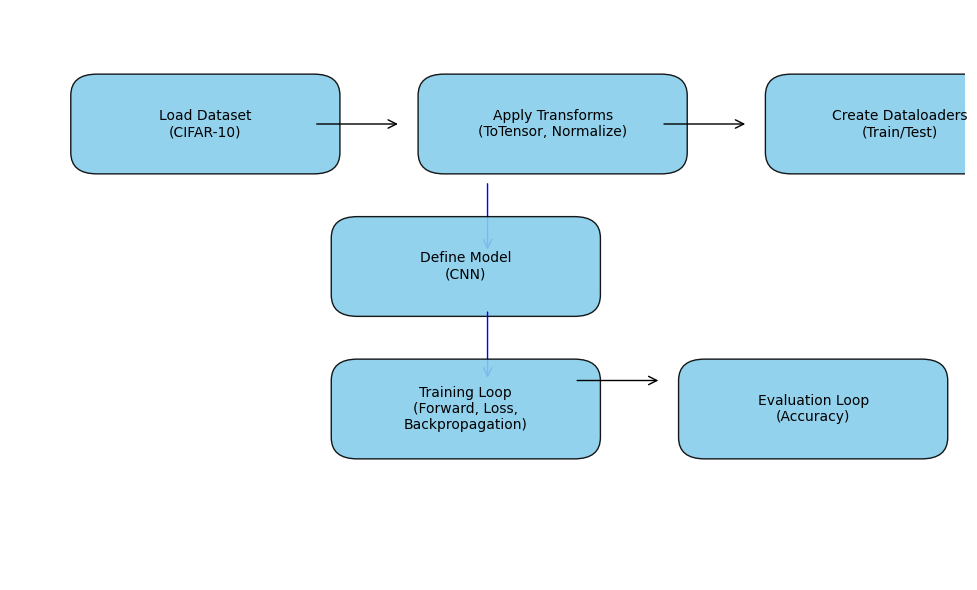

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Crear una figura
fig, ax = plt.subplots(figsize=(10, 6))

def add_box(ax, text, xy, width=2.5, height=0.8, color="skyblue"):
    box = FancyBboxPatch(
        xy,
        width,
        height,
        boxstyle="round,pad=0.3",
        edgecolor="black",
        facecolor=color,
        alpha=0.9,
    )
    ax.add_patch(box)
    ax.text(
        xy[0] + width / 2,
        xy[1] + height / 2,
        text,
        ha="center",
        va="center",
        fontsize=10,
        color="black",
    )

def add_arrow(ax, xy_start, xy_end, color="black"):
    arrow = FancyArrowPatch(
        xy_start, xy_end, arrowstyle="->", color=color, mutation_scale=15
    )
    ax.add_patch(arrow)

add_box(ax, "Load Dataset\n(CIFAR-10)", (0, 3))
add_arrow(ax, (2.5, 3.4), (3.5, 3.4))
add_box(ax, "Apply Transforms\n(ToTensor, Normalize)", (4, 3))
add_arrow(ax, (6.5, 3.4), (7.5, 3.4))
add_box(ax, "Create Dataloaders\n(Train/Test)", (8, 3))

add_arrow(ax, (4.5, 2.6), (4.5, 1.6), color="blue")
add_box(ax, "Define Model\n(CNN)", (3, 1))
add_arrow(ax, (4.5, 0.8), (4.5, -0.2), color="blue")
add_box(ax, "Training Loop\n(Forward, Loss,\nBackpropagation)", (3, -1))
add_arrow(ax, (5.5, -0.2), (6.5, -0.2))
add_box(ax, "Evaluation Loop\n(Accuracy)", (7, -1))

ax.set_xlim(-1, 10)
ax.set_ylim(-3, 5)
ax.axis("off")  # Ocultar ejes

plt.tight_layout()
plt.show()
